In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!pip install nltk pandas scikit-learn
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
import os
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer


def extract_messages(filename):
    with open(filename, 'r', encoding='utf-8', errors='ignore') as file:
        content = file.read()


    messages = re.split(r'\nFrom: ', content)
    message_data = []

    for msg in messages[1:]:

        subject_match = re.search(r'Subject: (.*)', msg)
        subject = subject_match.group(1) if subject_match else ''


        message_body = re.split(r'\n\n', msg, 1)[-1]


        message_data.append({'subject': subject, 'content': message_body})

    return pd.DataFrame(message_data)


def clean_text(text):
    text = text.lower()
    text = re.sub(r'\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b', '', text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def preprocess_data(df):

    df['cleaned_content'] = df['content'].apply(clean_text)
    df['tokens'] = df['cleaned_content'].apply(word_tokenize)


    stop_words = set(stopwords.words('english') + ['subject', 're', 'newsgroup'])
    df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

    lemmatizer = WordNetLemmatizer()
    df['tokens'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    df['processed_content'] = df['tokens'].apply(lambda x: ' '.join(x))

    return df

newsgroup_dir = '/content/drive/MyDrive/NLC Assignment'


all_data = []
for file in os.listdir(newsgroup_dir):
    if file.endswith('.txt'):
        newsgroup_name = file.replace('.txt', '')
        print(f"Processing: {newsgroup_name}")

        df = extract_messages(os.path.join(newsgroup_dir, file))

        df['newsgroup'] = newsgroup_name
        df = preprocess_data(df)
        all_data.append(df)


combined_df = pd.concat(all_data, ignore_index=True)
combined_df.to_csv('/content/drive/MyDrive/NLC Assignment/combined.csv', index=False)



vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(combined_df['processed_content'])

from scipy import sparse
sparse.save_npz('/content/drive/MyDrive/NLC Assignment/tfidf.npz', tfidf_matrix)



Processing: alt.atheism
Processing: comp.graphics
Processing: comp.os.ms-windows.misc
Processing: comp.sys.mac.hardware
Processing: comp.windows.x
Processing: comp.sys.ibm.pc.hardware
Processing: rec.autos
Processing: misc.forsale
Processing: rec.sport.baseball
Processing: rec.motorcycles
Processing: sci.med
Processing: sci.space
Processing: soc.religion.christian
Processing: rec.sport.hockey
Processing: sci.crypt
Processing: sci.electronics
Processing: talk.politics.misc
Processing: talk.religion.misc
Processing: talk.politics.mideast
Processing: talk.politics.guns


In [11]:
import pandas as pd
from scipy import sparse

combined_df = pd.read_csv('/content/drive/MyDrive/NLC Assignment/combined.csv')
tfidf_matrix = sparse.load_npz('/content/drive/MyDrive/NLC Assignment/tfidf.npz')


In [12]:
from sklearn.model_selection import train_test_split

X = tfidf_matrix
y = combined_df['newsgroup']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (31422, 5000)
Test set size: (7856, 5000)


NAIVE BAYES CLASSIFICATION


In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))


Naive Bayes Classifier:
Accuracy: 0.9212067209775967
Classification Report:
                           precision    recall  f1-score   support

             alt.atheism       0.88      0.95      0.91       528
           comp.graphics       0.82      0.92      0.87       491
 comp.os.ms-windows.misc       0.90      0.87      0.88       418
comp.sys.ibm.pc.hardware       0.87      0.96      0.91       431
   comp.sys.mac.hardware       0.96      0.94      0.95       389
          comp.windows.x       0.88      0.86      0.87       350
            misc.forsale       0.95      0.91      0.93       389
               rec.autos       0.97      0.96      0.97       402
         rec.motorcycles       0.98      0.98      0.98       415
      rec.sport.baseball       0.99      0.99      0.99       369
        rec.sport.hockey       1.00      0.99      0.99       400
               sci.crypt       0.96      0.95      0.96       403
         sci.electronics       0.93      0.92      0.92       39

SUPPORT VECTOR MACHINE

In [14]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print("Support Vector Machine Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))


Support Vector Machine Classifier:
Accuracy: 0.994908350305499
Classification Report:
                           precision    recall  f1-score   support

             alt.atheism       1.00      0.99      0.99       528
           comp.graphics       0.99      1.00      0.99       491
 comp.os.ms-windows.misc       1.00      0.99      0.99       418
comp.sys.ibm.pc.hardware       0.99      1.00      0.99       431
   comp.sys.mac.hardware       1.00      1.00      1.00       389
          comp.windows.x       0.99      0.99      0.99       350
            misc.forsale       1.00      0.98      0.99       389
               rec.autos       1.00      1.00      1.00       402
         rec.motorcycles       1.00      1.00      1.00       415
      rec.sport.baseball       1.00      1.00      1.00       369
        rec.sport.hockey       1.00      1.00      1.00       400
               sci.crypt       0.99      1.00      0.99       403
         sci.electronics       1.00      1.00      1.0

RANDOM FOREST CLASSIFIER

In [15]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Classifier:
Accuracy: 0.997581466395112
Classification Report:
                           precision    recall  f1-score   support

             alt.atheism       0.99      0.99      0.99       528
           comp.graphics       0.99      0.99      0.99       491
 comp.os.ms-windows.misc       1.00      1.00      1.00       418
comp.sys.ibm.pc.hardware       1.00      1.00      1.00       431
   comp.sys.mac.hardware       1.00      1.00      1.00       389
          comp.windows.x       1.00      0.99      1.00       350
            misc.forsale       1.00      1.00      1.00       389
               rec.autos       1.00      1.00      1.00       402
         rec.motorcycles       1.00      1.00      1.00       415
      rec.sport.baseball       1.00      1.00      1.00       369
        rec.sport.hockey       1.00      1.00      1.00       400
               sci.crypt       1.00      1.00      1.00       403
         sci.electronics       0.99      1.00      1.00       3

kmeans Clustering

In [16]:
from sklearn.cluster import KMeans

num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

clusters = kmeans.labels_

combined_df['cluster'] = clusters

for i in range(3):
    print(f"Cluster {i}:")
    print(combined_df[combined_df['cluster'] == i]['newsgroup'].value_counts().head(5))
    print("-" * 60)


Cluster 0:
newsgroup
rec.autos          1742
rec.motorcycles      44
sci.electronics      22
misc.forsale         18
alt.atheism           9
Name: count, dtype: int64
------------------------------------------------------------
Cluster 1:
newsgroup
comp.sys.ibm.pc.hardware    200
comp.os.ms-windows.misc     190
comp.graphics               145
comp.sys.mac.hardware        64
misc.forsale                 24
Name: count, dtype: int64
------------------------------------------------------------
Cluster 2:
newsgroup
talk.politics.mideast     1572
alt.atheism                 16
talk.politics.misc           8
talk.religion.misc           6
soc.religion.christian       4
Name: count, dtype: int64
------------------------------------------------------------


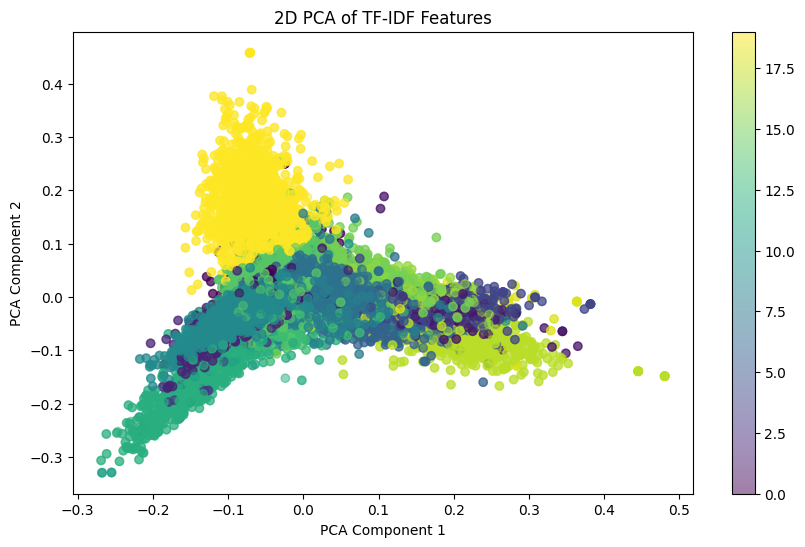

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title("2D PCA of TF-IDF Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [19]:
import joblib


joblib.dump(nb_model, '/content/drive/MyDrive/NLC Assignment/naive_bayes_model.pkl')
joblib.dump(svm_model, '/content/drive/MyDrive/NLC Assignment/svm_model.pkl')
joblib.dump(rf_model, '/content/drive/MyDrive/NLC Assignment/random_forest_model.pkl')
joblib.dump(vectorizer, '/content/drive/MyDrive/NLC Assignment/tfidf_vectorizer.pkl')



['/content/drive/MyDrive/NLC Assignment/tfidf_vectorizer.pkl']

In [20]:

nb_model = joblib.load('/content/drive/MyDrive/NLC Assignment/naive_bayes_model.pkl')
svm_model = joblib.load('/content/drive/MyDrive/NLC Assignment/svm_model.pkl')
vectorizer = joblib.load('/content/drive/MyDrive/NLC Assignment/tfidf_vectorizer.pkl')

new_text = input("Enter a news article: ")
new_text_vectorized = vectorizer.transform([new_text])

nb_prediction = nb_model.predict(new_text_vectorized)
svm_prediction = svm_model.predict(new_text_vectorized)

print(f"Naive Bayes prediction: {nb_prediction[0]}")
print(f"SVM prediction: {svm_prediction[0]}")


Enter a news article: Space
Naive Bayes prediction: sci.space
SVM prediction: sci.space


In [21]:
import joblib
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = joblib.load('/content/drive/MyDrive/NLC Assignment/tfidf_vectorizer.pkl')
tfidf_matrix = sparse.load_npz('/content/drive/MyDrive/NLC Assignment/tfidf.npz')

def find_related_articles(user_query, top_n=5):
    query_vector = vectorizer.transform([user_query])

    cosine_similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()
    top_indices = cosine_similarities.argsort()[-top_n:][::-1]


    related_articles = combined_df.iloc[top_indices]


    for i, (index, row) in enumerate(related_articles.iterrows()):
        print(f"Result {i+1}")
        print(f"Newsgroup: {row['newsgroup']}")
        print(f"Subject: {row['subject']}")
        print(f"Content: {row['content'][:500]}...")
        print("="*80)

user_input = input("Enter the news: ")
find_related_articles(user_input, top_n=5)


Enter the news: USA wars
Result 1
Newsgroup: sci.electronics
Subject: Re: Need to find out number to a phone line
Content:  In most areas of the country, serviced by ESS (or CESS), your phone
--

      * * * * * * * * * * * * * * * * * * * * * * * * * * *
      *               paula@nlbbs.com                     *
      *  Paula Stockholm            Cumberland, Maine USA *
      * * * * * * * * * * * * * * * * * * * * * * * * * * *

Newsgroup: sci.electronics
Document_id: 53941...
Result 2
Newsgroup: sci.electronics
Subject: Re: Need to find out number to a phone line
Content:  In most areas of the country, serviced by ESS (or CESS), your phone
--

      * * * * * * * * * * * * * * * * * * * * * * * * * * *
      *               paula@nlbbs.com                     *
      *  Paula Stockholm            Cumberland, Maine USA *
      * * * * * * * * * * * * * * * * * * * * * * * * * * *

Newsgroup: sci.electronics
document_id: 53941...
Result 3
Newsgroup: rec.sport.hockey
Subject: WC 93: 

USING LDA

In [22]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np


num_topics = 10

lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_matrix = lda_model.fit_transform(tfidf_matrix)
lda_matrix = np.array(lda_matrix)

def infer_query_topic_distribution(query):
    query_vector = vectorizer.transform([query])
    query_topic_dist = lda_model.transform(query_vector)
    return query_topic_dist


def find_related_articles_lda(user_query, top_n=5):

    query_topic_dist = infer_query_topic_distribution(user_query)


    cosine_similarities = cosine_similarity(query_topic_dist, lda_matrix).flatten()


    top_indices = cosine_similarities.argsort()[-top_n:][::-1]


    related_articles = combined_df.iloc[top_indices]


    for i, (index, row) in enumerate(related_articles.iterrows()):
        print(f"Result {i+1}")
        print(f"Newsgroup: {row['newsgroup']}")
        print(f"Subject: {row['subject']}")
        print(f"Content: {row['content'][:500]}...")
        print("="*80)


user_input = input("Enter the news: ")
find_related_articles_lda(user_input, top_n=5)


Enter the news: nasa
Result 1
Newsgroup: sci.electronics
Subject: nan
Content: Newsgroup: sci.electronics...
Result 2
Newsgroup: sci.electronics
Subject: nan
Content: Newsgroup: sci.electronics...
Result 3
Newsgroup: sci.electronics
Subject: nan
Content: Newsgroup: sci.electronics...
Result 4
Newsgroup: sci.electronics
Subject: nan
Content: Newsgroup: sci.electronics...
Result 5
Newsgroup: sci.space
Subject: Moonbase race
Content: 18084TM@msu.edu (Tom)
Subject: Moonbase race
...


In [23]:
pip install -U sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

USING TRANSFORMERS

In [24]:
from sentence_transformers import SentenceTransformer
import numpy as np


bert_model = SentenceTransformer('all-MiniLM-L6-v2')
# Ensure all entries in 'processed_content' are strings, filling NaNs with empty strings
combined_df['processed_content'] = combined_df['processed_content'].fillna("").astype(str)

# Generate document embeddings
document_embeddings = bert_model.encode(combined_df['processed_content'].tolist(), show_progress_bar=True)




def find_related_articles_bert(user_query, top_n=5):

    query_embedding = bert_model.encode([user_query])[0]


    similarities = cosine_similarity([query_embedding], document_embeddings)[0]


    top_indices = similarities.argsort()[-top_n:][::-1]


    related_articles = combined_df.iloc[top_indices]


    for i, (index, row) in enumerate(related_articles.iterrows()):
        print(f"Result {i+1}")
        print(f"Newsgroup: {row['newsgroup']}")
        print(f"Subject: {row['subject']}")
        print(f"Content: {row['content'][:500]}...")
        print("="*80)

user_input = input("Enter a keyword or phrase to find related articles: ")
find_related_articles_bert(user_input, top_n=5)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1228 [00:00<?, ?it/s]

Enter a keyword or phrase to find related articles: Racism
Result 1
Newsgroup: talk.politics.mideast
Subject: Re: Hamza Salah, the Humanist
Content: 
Mr. Salah, why are you such a homicidal racist?  Do you feel this
same hatred towards Christans, or is it only Jews?  Are you from
a family of racists?  Did you learn this racism in your home?  Or
are you a self-made bigot?  How does one become such a racist?  I
wonder what you think your racism will accomplish.  Are you under
the impression that your racism will help bring peace in the mid-
east?  I would like to know your thoughts on this.

Newsgroup: talk.politics.mideast
document_id: 76181...
Result 2
Newsgroup: talk.politics.mideast
Subject: Re: Hamza Salah, the Humanist
Content: 
Mr. Salah, why are you such a homicidal racist?  Do you feel this
same hatred towards Christans, or is it only Jews?  Are you from
a family of racists?  Did you learn this racism in your home?  Or
are you a self-made bigot?  How does one become such a racis

STREAMLIT DASHBOARD CODES

In [ ]:
!pip install streamlit pyngrok -q
!pip install sentence-transformers -q
!pip install seaborn matplotlib -q
# Install Node.js
!apt-get install nodejs npm -y

# Install localtunnel globally
!npm install -g localtunnel



In [ ]:
%%writefile app.py
import streamlit as st
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from sklearn.decomposition import LatentDirichletAllocation
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load data and models
combined_df = pd.read_csv('/content/drive/MyDrive/NLC Assignment/combined.csv')
tfidf_matrix = sparse.load_npz('/content/drive/MyDrive/NLC Assignment/tfidf.npz')

nb_model = joblib.load('/content/drive/MyDrive/NLC Assignment/naive_bayes_model.pkl')
svm_model = joblib.load('/content/drive/MyDrive/NLC Assignment/svm_model.pkl')
rf_model = joblib.load('/content/drive/MyDrive/NLC Assignment/random_forest_model.pkl')
vectorizer = joblib.load('/content/drive/MyDrive/NLC Assignment/tfidf_vectorizer.pkl')
lda_model = LatentDirichletAllocation(n_components=10, random_state=42).fit(tfidf_matrix)

bert_model = SentenceTransformer('all-MiniLM-L6-v2')
document_embeddings = bert_model.encode(combined_df['processed_content'].tolist(), show_progress_bar=True)

# Helper functions
def predict_classifiers(text):
    vectorized_text = vectorizer.transform([text])
    nb_prediction = nb_model.predict(vectorized_text)[0]
    svm_prediction = svm_model.predict(vectorized_text)[0]
    rf_prediction = rf_model.predict(vectorized_text)[0]
    return nb_prediction, svm_prediction, rf_prediction

def find_related_articles(user_query, model_choice='TF-IDF', top_n=5):
    query_vector = vectorizer.transform([user_query])
    if model_choice == 'TF-IDF':
        cosine_similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()
    elif model_choice == 'LDA':
        lda_matrix = lda_model.transform(tfidf_matrix)
        query_topic_dist = lda_model.transform(query_vector)
        cosine_similarities = cosine_similarity(query_topic_dist, lda_matrix).flatten()
    else:  # BERT
        query_embedding = bert_model.encode([user_query])[0]
        cosine_similarities = cosine_similarity([query_embedding], document_embeddings)[0]

    top_indices = cosine_similarities.argsort()[-top_n:][::-1]
    return combined_df.iloc[top_indices]

# Streamlit interface
st.title("📰 NLC Assignment Dashboard 🎉")
st.sidebar.markdown("## **📋 Choose Mode**")
mode = st.sidebar.radio("Select a feature", ["Classifier Predictions", "Find Related Articles", "Cluster Visualization"])

if mode == "Classifier Predictions":
    st.subheader("🤖 **Classifier Predictions**")
    user_input = st.text_area("🔍 Enter a news article:", placeholder="Type something interesting...")

    if st.button("🚀 Predict Class"):
        if user_input.strip():
            nb_pred, svm_pred, rf_pred = predict_classifiers(user_input)
            st.success(f"**Naive Bayes:** {nb_pred} 🟡")
            st.info(f"**SVM:** {svm_pred} 🔵")
            st.warning(f"**Random Forest:** {rf_pred} 🟢")
        else:
            st.error("⚠️ Please enter valid text.")

elif mode == "Find Related Articles":
    st.subheader("🔗 **Find Similar Articles**")
    user_input = st.text_area("📄 Enter a query or article:", placeholder="Looking for something specific?")
    model_choice = st.selectbox("💡 Choose a similarity model:", ["TF-IDF", "LDA", "BERT"])

    if st.button("🔍 Find Articles"):
        if user_input.strip():
            related_articles = find_related_articles(user_query=user_input, model_choice=model_choice)
            st.write(f"### Top Articles Using **{model_choice}**")
            for i, row in related_articles.iterrows():
                st.markdown(f"**{i+1}. {row['subject']}**")
                st.write(row['content'][:300] + "...")
                st.write("-" * 40)
        else:
            st.error("⚠️ Please enter a query.")

elif mode == "Cluster Visualization":
    st.subheader("📊 **Cluster Visualization**")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(tfidf_matrix.toarray())

    kmeans = joblib.load('/content/drive/MyDrive/NLC Assignment/kmeans_model.pkl')
    clusters = kmeans.labels_

    df_plot = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
    df_plot['Cluster'] = clusters

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='cool', data=df_plot, ax=ax)
    st.pyplot(fig)


In [ ]:
!wget -q -O - ipv4.icanhazip.com

In [ ]:
!lt --port 8501
